<a href="https://colab.research.google.com/github/victorsergio/mlp-pedestrian-prediction-keras/blob/master/MLP_Pedestrian_Trajectory_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function

import glob
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

import numpy as np
import pandas as pd
import re
from google.colab import drive
from pandas import read_csv
from numpy import array
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adagrad
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras.constraints import maxnorm
from keras.models import load_model
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.utils import plot_model
import random
from sklearn.preprocessing import MinMaxScaler


Using TensorFlow backend.


In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# For use TensorBoard on Colab
!pip install -U tensorboardcolab

from tensorboardcolab import *
tensorboard_callback=TensorBoardColab()

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)
Wait for 8 seconds...
TensorBoard link:
http://ca1eaefb.ngrok.io


In [0]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
        
    return array(X), array(y)

In [0]:
def sequences_to_supervised(dataframe, n_steps, n_features):
  
  # the sequences must by arranged
  # in a supervised learning structure.
  # this function reads line by line each sequence and arrange in a supervised learning aproach structure
  # it's important to notice that sequences must not overlap, to mantain pedestrian independence
       
  X_all = np.empty([0,n_steps,n_features]) # n_features = number of features, x, y, time
  y_all = np.empty([0,n_features]) # same here, n_features = number of features
       
  dataframe_groups = dataframe.groupby(['id'])
  
  # randomize sequences grouped by pedestrian id
  groups = list(dataframe.groupby(['id']))
  random.shuffle(groups)
 

  for group in groups:
      
      # send pedestrian sequence dataframe to step sequence generator function
      #X, y = split_sequences(group[1].drop(columns=["id"]).values, n_steps) #use 3 features, time, x, y
      X, y = split_sequences(group[1].drop(columns=["id","time"]).values, n_steps) # use 2 features, x, y
         
      X_all = np.concatenate((X_all,X))
      y_all = np.concatenate((y_all,y))
             
  return X_all, y_all         

In [0]:
# split a multivariate dataset into train/test sets
def split_dataset(X,y,train_samples,test_samples):
   
  X_train = X[0:train_samples,:,:]
  X_test  = X[train_samples:(train_samples+test_samples),:,:]
  
  y_train = y[0:train_samples,:]
  y_test =  y[train_samples:(train_samples+test_samples),:]
  
  return X_train, y_train, X_test, y_test

In [0]:
# hyperparameters

# choose a number of time steps
# previous time steps for each sequence split
n_steps = 8

#n_features = 3  # time, x, y
n_features = 2   #x, y

In [0]:
# path variables

base_path = "/content/drive/My Drive/Pedestrian Trajectory Prediction 2019/MLP/"
data_path = "/content/drive/My Drive/Pedestrian Trajectory Prediction 2019/MLP/data/train/"
test_path = "/content/drive/My Drive/Pedestrian Trajectory Prediction 2019/MLP/data/test/"


inputFileName = "bookstore_0.txt"

In [9]:
import glob

dataframe = pd.concat([pd.read_csv(f, sep=' ', header=None, names=['time', 'id', 'x', 'y']) for f in glob.glob(data_path+'bookstore_*.txt')], ignore_index=True)

#dataframe = pd.read_csv(data_path + inputFileName, sep=' ', header=None, names=['time', 'id', 'x', 'y'])
dataframe.head(50)

,time,id,x,y
0,0,100,757.0,918.5
1,12,100,765.0,918.5
2,24,100,773.0,918.5
3,36,100,780.5,918.5
4,48,100,788.5,919.5
5,60,100,796.5,919.5
6,72,100,804.5,919.5
7,84,100,810.5,919.5
8,96,100,818.5,919.5
9,108,100,822.5,922.0


In [0]:
#Function to work with relative coordinates, not working yet

#id_column = dataframe['id']

#dataframe = dataframe.groupby(['id']).diff(1)

#dataframe.loc[dataframe['x'].isnull(), 'x'] = 0.0
#dataframe.loc[dataframe['y'].isnull(), 'y'] = 0.0
#dataframe.loc[dataframe['time'].isnull(), 'time'] = 0.0

#dataframe = dataframe.join(id_column) # re insert the id column to the scaled dataframe

#dataframe.head(50)


In [10]:
# min max scaling
# normalize all columns but not id column

id_column = dataframe['id']
dataframe = dataframe.drop(columns="id")

scaler = MinMaxScaler()
dataframe = pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

dataframe = dataframe.join(id_column) # re insert the id column to the scaled dataframe

X, y = sequences_to_supervised(dataframe, n_steps, n_features)

# show the prepared data dimensions with the supervised learning structure
# multivariate input, multivariate output, single step output, multistep input
print("supervised dataframe dimensions: ")
print(X.shape, y.shape,"\n")

# show first 3 elements
for i in range(3):
    print(X[i], y[i])

supervised dataframe dimensions: 
(28992, 8, 2) (28992, 2) 

[[0.53287972 0.85046729]
 [0.53856764 0.85046729]
 [0.54425556 0.85046729]
 [0.54958798 0.85046729]
 [0.5552759  0.85140187]
 [0.56096382 0.85140187]
 [0.56665174 0.85140187]
 [0.57091767 0.85140187]] [0.57660559 0.85140187]
[[0.53856764 0.85046729]
 [0.54425556 0.85046729]
 [0.54958798 0.85046729]
 [0.5552759  0.85140187]
 [0.56096382 0.85140187]
 [0.56665174 0.85140187]
 [0.57091767 0.85140187]
 [0.57660559 0.85140187]] [0.57944955 0.85373832]
[[0.54425556 0.85046729]
 [0.54958798 0.85046729]
 [0.5552759  0.85140187]
 [0.56096382 0.85140187]
 [0.56665174 0.85140187]
 [0.57091767 0.85140187]
 [0.57660559 0.85140187]
 [0.57944955 0.85373832]] [0.57944955 0.85373832]


In [11]:

# split into train and test
X, y, X_test, y_test = split_dataset(X,y,23000,5992)

# print train and test set dimensions
print("\ntrain set: ",X.shape, y.shape,"\n")
print("test set: ",X_test.shape, y_test.shape,"\n")  



train set:  (23000, 8, 2) (23000, 2) 

test set:  (5992, 8, 2) (5992, 2) 



In [0]:
# flatten input
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))


# separate output
y1 = y[:, 0].reshape((y.shape[0], 1))  # time or x with 2 features 
y2 = y[:, 1].reshape((y.shape[0], 1))  # x or y with 2 features
# y3 = y[:, 2].reshape((y.shape[0], 1))  # y


# flatten test input
n_input = X_test.shape[1] * X_test.shape[2]
X_test = X_test.reshape((X_test.shape[0], n_input))

# separate test output
y1_test = y_test[:, 0].reshape((y_test.shape[0], 1)) # time or x with 2 features
y2_test = y_test[:, 1].reshape((y_test.shape[0], 1)) # x or y with 2 features
# y3_test = y_test[:, 2].reshape((y_test.shape[0], 1)) # y


In [0]:
batch_size = 16
learning_rate = 0.003

In [14]:
# define model
visible = Input(shape=(n_input,))
#dropout_visible = Dropout(0.1)(visible)

dense1 = Dense(2048, name='dense_1', use_bias=False, kernel_regularizer=regularizers.l2(0.1),kernel_constraint=maxnorm(10))(visible)
activation1 = Activation('relu')(dense1)
batchnorm1 = BatchNormalization()(activation1)
dropout1 = Dropout(0.4)(batchnorm1)

dense2 = Dense(1024,  name='dense_2', use_bias=False, activation='relu',kernel_regularizer=regularizers.l2(0.1),kernel_constraint=maxnorm(10))(dropout1)
activation2 = Activation('relu')(dense2)
batchnorm2 = BatchNormalization()(activation2)
dropout2 = Dropout(0.4)(batchnorm2)

dense3 = Dense(512,  name='dense_3',use_bias=False, activation='relu',kernel_regularizer=regularizers.l2(0.1),kernel_constraint=maxnorm(10))(dropout2)
activation3 = Activation('relu')(dense3)
batchnorm3 = BatchNormalization()(activation3)
dropout3 = Dropout(0.4)(batchnorm3)

#dense4 = Dense(128,  name='dense_4',use_bias=False, activation='relu',kernel_regularizer=regularizers.l2(0.0),kernel_constraint=maxnorm(10))(dropout3)
#activation4 = Activation('relu')(dense4)
#batchnorm4 = BatchNormalization()(activation4)
#dropout4 = Dropout(0.5)(batchnorm4)

# define output 1
output1 = Dense(1, name='x_output_1')(dropout3)
# define output 2
output2 = Dense(1, name='y_output_2')(dropout3)
# define output 3
#output3 = Dense(1, name='y_output_3')(dropout3)



W0805 21:41:50.248313 140101792450432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 21:41:50.268015 140101792450432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 21:41:50.272632 140101792450432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 21:41:50.359202 140101792450432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0805 21:41:50.384357 

In [15]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

W0805 21:42:00.621436 140101792450432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

In [16]:
optimizer = Adagrad(lr=learning_rate, epsilon=None, decay=0.0)

# tie together
#model = Model(inputs=visible, outputs=[output1, output2, output3])

# 2 features x, y
model = Model(inputs=visible, outputs=[output1, output2])

model.compile(optimizer=optimizer, loss='mse',metrics=['mae'])

# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file=base_path+'graphs/MLP-bookstore-graph.png')

W0805 21:42:04.135652 140101792450432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2048)         32768       input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 2048)         0           dense_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 2048)         8192        activation_1[0][0]               
__________________________________________________________________________________________________
dropout_1 

In [0]:

# checkpoint
filepath = base_path + "models/MLP-bookstore-model-weights.best.hdf5"
checkpoint_call = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# tensorboard
tboard_call = TensorBoardColabCallback(tensorboard_callback)

# callbacks
callbacks_list = [checkpoint_call,tboard_call]


In [0]:
#UNCOMMENT AND RUN THIS SECTION FOR RELOAD THE MODEL FROM LAST .HDF5 FILE AND CONTINUE TRAINING

# Reload model for re-training

#model = load_model(base_path+'models/MLP-bookstore-model-weights.best.hdf5')

In [18]:
# fit model
#history = model.fit(X, [y1,y2,y3], epochs=200, verbose=0, validation_split=0.20, batch_size=batch_size,callbacks=callbacks_list)

# 2 features x,y
history = model.fit(X, [y1,y2], epochs=200, verbose=0, validation_split=0.20, batch_size=batch_size,callbacks=callbacks_list) 


W0805 21:42:18.093261 140101792450432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorboardcolab/core.py:49: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W0805 21:42:18.302402 140101792450432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.




Epoch 00001: val_loss improved from inf to 23.47563, saving model to /content/drive/My Drive/Pedestrian Trajectory Prediction 2019/MLP/models/MLP-bookstore-model-weights.best.hdf5

Epoch 00002: val_loss improved from 23.47563 to 9.41807, saving model to /content/drive/My Drive/Pedestrian Trajectory Prediction 2019/MLP/models/MLP-bookstore-model-weights.best.hdf5

Epoch 00003: val_loss improved from 9.41807 to 4.78228, saving model to /content/drive/My Drive/Pedestrian Trajectory Prediction 2019/MLP/models/MLP-bookstore-model-weights.best.hdf5

Epoch 00004: val_loss improved from 4.78228 to 2.74017, saving model to /content/drive/My Drive/Pedestrian Trajectory Prediction 2019/MLP/models/MLP-bookstore-model-weights.best.hdf5

Epoch 00005: val_loss improved from 2.74017 to 1.69120, saving model to /content/drive/My Drive/Pedestrian Trajectory Prediction 2019/MLP/models/MLP-bookstore-model-weights.best.hdf5

Epoch 00006: val_loss improved from 1.69120 to 1.08885, saving model to /content/

KeyboardInterrupt: ignored

In [0]:
model = load_model(base_path+'models/MLP-bookstore-model-weights.best.hdf5')

In [20]:
#score = model.evaluate(X_test, [y1_test,y2_test,y3_test], verbose=1, batch_size=batch_size)

# 2 features, x, y
score = model.evaluate(X_test, [y1_test,y2_test], verbose=1, batch_size=batch_size)

print("\n")
print(model.metrics_names)
print(score)

5992/5992 [==============================] - 1s 165us/step


['loss', 'x_output_1_loss', 'y_output_2_loss', 'x_output_1_mean_absolute_error', 'y_output_2_mean_absolute_error']
[0.014211689873669392, 0.005635996101412704, 0.0058598875428199065, 0.023387300662537202, 0.025143913161233367]


In [21]:
print("Min values: ", scaler.data_min_)
print("Max value: ",scaler.data_max_)

mae_x = scaler.inverse_transform(array([0,score[3],0]).reshape(1, -1))
mae_y = scaler.inverse_transform(array([0,0,score[4]]).reshape(1, -1))

print("MAE X:",score[3],"MAE Y:",score[4])
print("MAE X: ", mae_x[0][1],"MAE Y:",mae_y[0][2] )

Min values:  [0.   7.51 8.5 ]
Max value:  [14532.   1414.   1078.5]
MAE X: 0.023387300662537202 MAE Y: 0.025143913161233367
MAE X:  40.40400450885195 MAE Y: 35.403987082519706


In [0]:
def test_predictions(n_input,sample):

    #path = "/content/drive/My Drive/research/data/stanford-image/"
    inputFileName = "bookstore_3.txt"
    
    

    # choose a number of time steps
    # previous time steps for each sequence split
    n_steps = 8
    n_features = 2  # x, y

    dataframe = pd.read_csv(test_path + inputFileName, sep=' ', header=None, names=['time', 'id', 'x', 'y'])


    # convert absolute coordinates to relative coordinates, note working yet
    #id_column = dataframe['id']
    
    #dataframe = dataframe.groupby(['id']).diff(1)

    #dataframe.loc[dataframe['x'].isnull(), 'x'] = 0.0
    #dataframe.loc[dataframe['y'].isnull(), 'y'] = 0.0
    #dataframe.loc[dataframe['time'].isnull(), 'time'] = 0.0

    #dataframe = dataframe.join(id_column) # re insert the id column to the scaled dataframe

    



    # min max scaling
    # normalize all columns but not id column

    id_column = dataframe['id']
    dataframe = dataframe.drop(columns=["id","time"])

    scaler = MinMaxScaler()
    dataframe = pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

    dataframe = dataframe.join(id_column) # re insert the id column to the scaled dataframe
    
    
    dataframe_groups = dataframe.groupby(['id'])
  
    # randomize sequences grouped by pedestrian id
    groups = list(dataframe.groupby(['id']))
    random.shuffle(groups)
 

    
    g = groups[sample]
    
    print(g[0])
  
    pedestrian_group = g[1].drop(columns="id").values

    #print("ground")
    #print(pedestrian_group)
    
    #window = pedestrian_group[0:8,:]
   
    predicted_trajectory = pedestrian_group[0:8,:] # initial points
      
    multistep = 1    # =1 for a step ahead prediction
    
    
    for j in range(0,pedestrian_group.shape[0]-8,multistep):
    #for j in range (0,1):
        input_steps = pedestrian_group[j:j+8,:]
        #window = pedestrian_group[0:8,:]
        #print(input_steps)
        #for i in range(0,multistep):
        
        #input_steps = window[i:i+8,:]
        
        x_input = input_steps.reshape(1,n_input)        
        yhat = model.predict(x_input,verbose=0)
        
               
        yhat_results = np.array([yhat[0][0],yhat[1][0]]).reshape(1,-1)
        #print(x_input)
        predicted_trajectory = np.append(predicted_trajectory, yhat_results,axis=0)
        #window = np.append(window,yhat_results,axis=0)
        
        
    
    
    #print(predicted_trajectory)    
        
    predicted = scaler.inverse_transform(predicted_trajectory)
    ground_truth = scaler.inverse_transform(pedestrian_group)
    
    #convert relative coordinates to absolute coordinates to display

    #print(predicted_trajectory)
    #predicted = np.sum(predicted, axis=1)

    #print(predicted)

    e = 0
    
    for i in range(0,len(predicted)):
        e = e + math.sqrt (((predicted[i,0]- ground_truth[i,0]) ** 2) + ((predicted[i,1]- ground_truth[i,1]) ** 2))
        
    e = e / len(predicted)
    
    
    d = 0
    d = d + math.sqrt (((predicted[len(predicted)-1,0]- ground_truth[len(ground_truth)-1,0]) ** 2) + ((predicted[len(predicted)-1,1]- ground_truth[len(ground_truth)-1,1]) ** 2))
    
    
        
    print("L2 error: ",e)
    print("Displacement error:",d)
    print("predicted shape:",predicted.shape)
    print("predicted values:\n",predicted)
    print("ground truth values:\n",ground_truth)
    
    
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
 
    # Prints: [8.0, 6.0]
    #print ("Current size:", fig_size)
 
    # Set figure width to 12 and height to 9
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    
    
    img = plt.imread(base_path+"background/bookstore_video0.jpg")
    fig, ax = plt.subplots()
    
    #x = range(300)
    #ax.imshow(img, extent=[0, 400, 0, 300])
    ax.imshow(img)    
    #ax.style.use('seaborn-whitegrid')
    ax.plot(ground_truth[:,0],ground_truth[:,1],'-o',color='red')
    ax.plot(predicted[:,0],predicted[:,1],'-o',color='green')
    plt.show()
    
    
    



163
L2 error:  14.236844396885264
Displacement error: 26.903682721032208
predicted shape: (20, 2)
predicted values:
 [[488.         397.5       ]
 [477.         406.5       ]
 [467.5        417.5       ]
 [456.5        426.5       ]
 [447.5        435.5       ]
 [436.5        447.        ]
 [425.5        456.        ]
 [416.5        465.        ]
 [424.48376682 463.10139842]
 [413.46021849 474.5790942 ]
 [403.64292954 484.3636325 ]
 [392.68202338 494.36697572]
 [380.38301836 508.82925302]
 [368.02148753 522.98127696]
 [355.89027821 540.76682426]
 [343.69060855 548.19849715]
 [331.86880888 556.93707824]
 [321.37657477 565.68243563]
 [309.37594431 572.61370704]
 [298.86196968 581.08604908]]
ground truth values:
 [[488.  397.5]
 [477.  406.5]
 [467.5 417.5]
 [456.5 426.5]
 [447.5 435.5]
 [436.5 447. ]
 [425.5 456. ]
 [416.5 465. ]
 [405.5 476. ]
 [396.  485. ]
 [385.  494. ]
 [372.5 507.5]
 [359.5 521. ]
 [346.5 539. ]
 [333.5 545.5]
 [321.  554.5]
 [310.  563.5]
 [297.  570.5]
 [286.  57

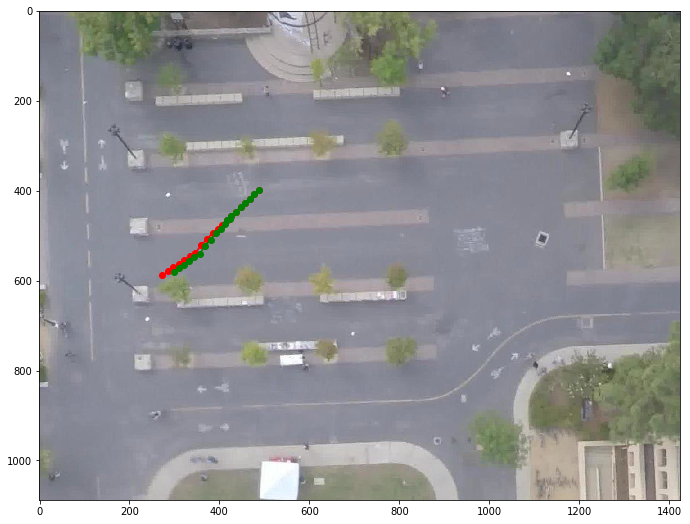

In [55]:
#n_input = 16
#test_predictions(n_input=n_input,sample = 40)

# n_input = 16 for MLP models
# sample is a specific index trajectory on the dataset
test_predictions(n_input=16, sample = 1)

In [0]:
# code for create a new graph on tensorboard for each training 

import os
os.rename("Graph/training","Graph/training-01")
os.rename("Graph/validation","Graph/validation-01")